# QISKIT Example
This is the same QuTiP example worked out in IBM's QISKIT, it follows closely David's QuTiP demo as well as the tutorials laid out in https://github.com/QISKit/qiskit-tutorial

## Setting up

In [1]:
# Checking the version of PYTHON
import sys
if sys.version_info < (3,0):
    raise Exception('Please use Python version 3 or greater.')
    
# useful additional packages 
import matplotlib.pyplot as plt
#%matplotlib inline
import numpy as np

# Optional - point to the folder which contains your QConfig file
#import sys
#sys.path.append('/Users/sabreitweiser/qiskit-sdk-py/')

# importing the QISKit
from qiskit import QuantumCircuit, QuantumProgram
import Qconfig

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

#backend = 'ibmqx4' # the backend to run on
shots = 1024   # the number of shots in the experiment. 
backend = 'local_qasm_simulator' # the backend for testing

QPS_SPECS = {
    'circuits': [{
        'name': 'measure',
        'quantum_registers': [{
            'name':'q',
            'size':1
        }],
        'classical_registers': [{
            'name':'c',
            'size':1
        }]}],
}

Q_program = QuantumProgram(specs=QPS_SPECS)
Q_program.set_api(Qconfig.APItoken, Qconfig.config['url'])

## Expectation values
This is just a one-qubit circuit!

In [2]:
q = Q_program.get_quantum_register('q')
c = Q_program.get_classical_register('c')

# quantum circuit to produce the X state
prepX = Q_program.create_circuit('prepX', [q], [c])
prepX.h(q[0])

# quantum circuit to measure q in Z basis 
measureZ = Q_program.create_circuit('measureZ', [q], [c])
measureZ.measure(q[0], c[0])

# quantum circuit to measure q in X basis 
measureX = Q_program.create_circuit('measureX', [q], [c])
measureX.h(q[0])
measureX.measure(q[0], c[0])

# quantum circuit to measure q in Y basis 
measureY = Q_program.create_circuit('measureY', [q], [c])
measureY.s(q[0]).inverse()
measureY.h(q[0])
measureY.measure(q[0], c[0])

Q_program.add_circuit('expX', prepX + measureX )
Q_program.add_circuit('expY', prepX + measureY )
Q_program.add_circuit('expZ', prepX + measureZ )

circuits = ['expX', 'expY', 'expZ']
Q_program.get_qasms(circuits)
result = Q_program.execute(circuits, backend=backend, shots=shots, max_credits=3, wait=10, timeout=240)

In [3]:
result.get_status()

'COMPLETED'

In [4]:
def expect(result, circuit):
    #returns the expectation value given the results of a 1 bit measurement
    #assumes the eigenvalues are +1 for |0> and -1 for |1>
    counts = result.get_counts(circuit)
    p = counts.get('0', 0)
    m = counts.get('1', 0)
    return (p - m) / shots

x = expect(result, 'expX')
y = expect(result, 'expY')
z = expect(result, 'expZ')


(x,y,z)

(1.0, 0.0, -0.05859375)

## Spin Hamiltonian

Note that, due to limitations on measurement, we need to redo the experiment for every time step

In [5]:
H = 2*0.28 # the splitting, in GHz
t = 0.5 # time step, in ns
steps = 40 #number of steps to take

# quantum circuit to produce the Z state
prepZ = Q_program.create_circuit('prepZ', [q], [c])
#NB: Don't actually need to do anything here

evolve = Q_program.create_circuit('evolve', [q], [c])
evolve.rx(H*t, q[0]) #Rotate around the x axis by H*t

circuits = []
for i in range(steps):
    prep_and_evolve = prepZ
    for j in range(i):
        prep_and_evolve = prep_and_evolve + evolve
    
    expX = prep_and_evolve + measureX
    expY = prep_and_evolve + measureY
    expZ = prep_and_evolve + measureZ
    
    Q_program.add_circuit('expX' + str(i), expX )
    Q_program.add_circuit('expY' + str(i), expY )
    Q_program.add_circuit('expZ' + str(i), expZ )
    
    circuits.append('expX' + str(i))
    circuits.append('expY' + str(i))
    circuits.append('expZ' + str(i))

Q_program.get_qasms(circuits)
result = Q_program.execute(circuits, backend=backend, shots=shots, max_credits=3, wait=10, timeout=240)

In [6]:
result.get_status()

'COMPLETED'

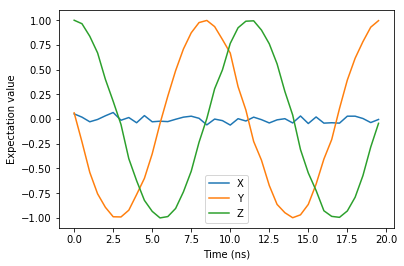

In [11]:
x = []
y = []
z = []

for i in range(steps):
    x.append(expect(result, 'expX' + str(i)))
    y.append(expect(result, 'expY' + str(i)))
    z.append(expect(result, 'expZ' + str(i)))
    
time = t*np.array(range(steps))
plt.plot(time,x)
plt.plot(time,y)
plt.plot(time,z)
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend(['X', 'Y', 'Z'])
plt.show()